# Project 13 - Taxi Orders for the Next Hour

## Project Description
Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

### Steps of the Project
1. Initialization
2. Data Overview
3. Data Pre-Processing
4. Explorative Data Analysis
5. Model Training and Validation
6. Model Testing
7. Conclusion

### Data Description

The data you need is stored in the taxi.csv file. 
The number of orders can be found in the `num_orders` column.

## Initialization

In [1]:
!pip install catboost

In [41]:
# Common Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.simplefilter('ignore')

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

# Statistics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

## Data Overview

In [3]:
# insert dataset
df = pd.read_csv('taxi.csv')

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
#information of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
#statstical description of data
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Data Pre-Processing

### Duplicate & Missing Values

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

**Findings :**
- Dataset contains 2 columns (datetime & num_orders) with 26.496 rows
- The duplicates or missing value are not found
- The 'datetime' column will be convert to timestamp format to simplify analyze

### Resample

In [9]:
# convert datetime to timestamp format
df['datetime'] =  pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f')

In [10]:
# set table index
df.set_index('datetime', inplace=True)

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [12]:
# resample data within per hour
df_new = df.resample('1H').sum().reset_index()
df_new.shape

(4416, 2)

In [13]:
df_new.set_index('datetime', inplace=True)

In [14]:
# ratio for new dataset
len(df_new)/len(df)*100

16.666666666666664

### Features Engineering

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

In [16]:
make_features(df_new, 3, 5)

In [17]:
df_new.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,77.8
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,54.2
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,39.6
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,28.4


**Findings :**
- New dataset contain around 16% from old dataset after resampling which is 4416 rows
- New columns such as month, date, and hour are added for knowing when the taxi order occurred
- 3 lag Features and mean average of 5 also added to gain some information about previous values and 'smooth' the distribution of data

## Explorative Data Analysis

In [18]:
# create new df without features
df_clean = df_new[['num_orders']]

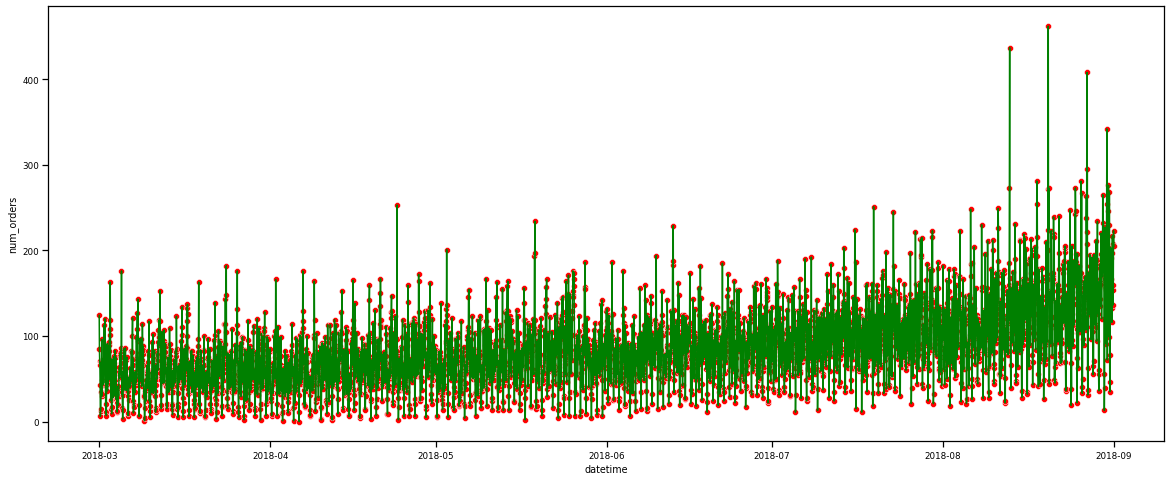

In [19]:
plt.figure(figsize = (20,8))
sns.set_context(context='notebook', font_scale=0.8)
sns.scatterplot(x='datetime', y ='num_orders', color='red', data=df_new)
sns.lineplot(x='datetime', y='num_orders',color='green', data=df_new)
plt.show()

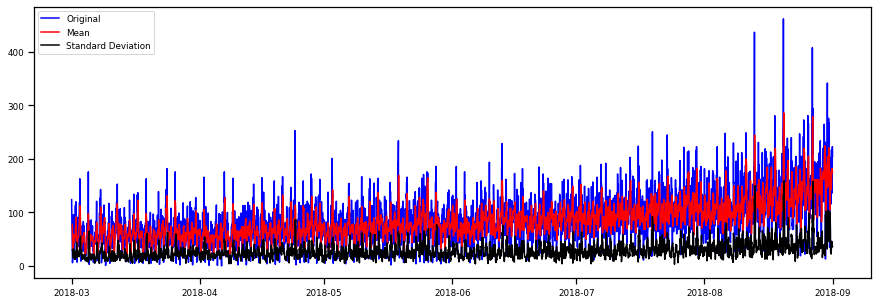

In [20]:
# mean & standard deviation distribution
mean = df_clean.rolling(5).mean()
std = df_clean.rolling(5).std()

plt.figure(figsize=(15,5))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(df_clean, color='blue',label='Original')
mean = plt.plot(mean, color='red', label='Mean')
std = plt.plot(std, color='black', label ='Standard Deviation')
plt.legend(loc='best')
plt.show()

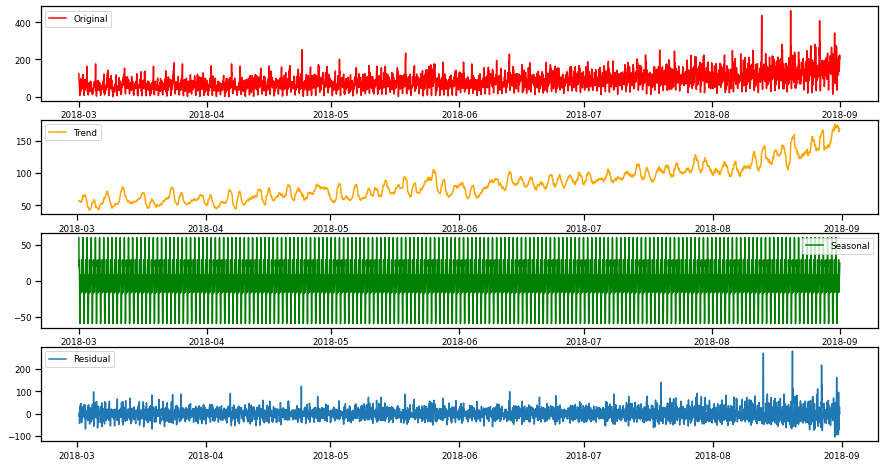

In [21]:
# trend & seasonal distribution
decomposed = seasonal_decompose(df_clean)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(15,8))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(df_clean, color='red', label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, color='orange', label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, color='green', label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.show()

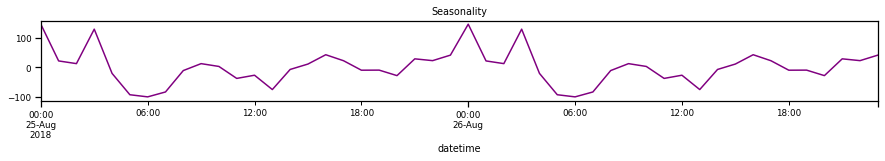

In [22]:
# data distribution cycle
decomposed_resample = seasonal_decompose(df_clean['2018-08-25':'2018-08-26'])

plt.figure(figsize=(15, 5))
plt.subplot(312)
decomposed_resample.seasonal.plot(ax=plt.gca(), color='purple')
plt.title('Seasonality')
plt.show()

**Findings :**
- The first and second paragraphs gives information about non-stationary distribution of taxi orders in 6 months period
- The trend graphic shows the taxi orders in the end of period increase about 3 times from the beginning of period
- There is a cycle in seasonal graphic that shows the highest order for a taxi happen around midnight to dawn, while the least time happen at the beginning of sunrise

## Model Training & Validation

In [23]:
# separate train-valid-test data
train_valid, test = train_test_split(df_new, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

train = train.dropna()

In [24]:
# separate fetures-target
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

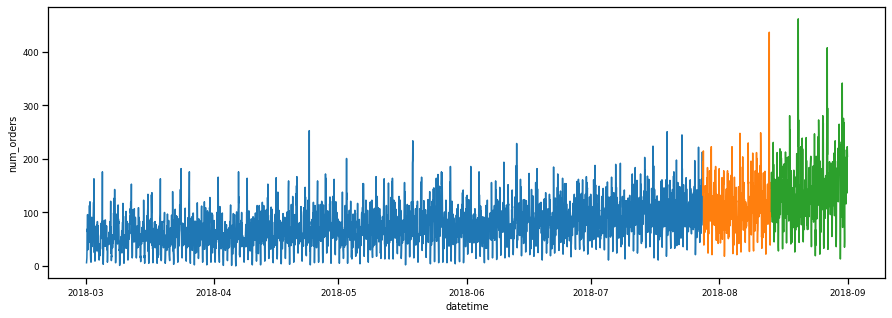

In [25]:
# train-valid-test data distribution
plt.figure(figsize=(15,5))
sns.lineplot(features_train.index, target_train);
sns.lineplot(features_valid.index, target_valid);
sns.lineplot(features_test.index, target_test);
plt.show()

### RMSE Function

In [38]:
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

### Linear Regression

In [39]:
# train the model
lr = LinearRegression()  
lr.fit(features_train, target_train)

# prediction
pred_train_lr = lr.predict(features_train)
pred_valid_lr = lr.predict(features_valid)

In [40]:
print('RMSE Train:', rmse(target_train, pred_train_lr))
print('RMSE Valid:', rmse(target_valid, pred_valid_lr))

RMSE Train: 29.22879822574998
RMSE Valid: 40.52169190479134


### Random Forest

In [29]:
random_forest = []

for depth_rf in range(1, 6):
    for est_rf in range(10, 51, 10):
        rfr = RandomForestRegressor(max_depth=depth_rf, n_estimators=est_rf, random_state=12345)
        rfr.fit(features_train, target_train)
    
        pred_train_rf = rfr.predict(features_train)
        pred_valid_rf = rfr.predict(features_valid)
    
        train_rf_rmse = rmse(target_train, pred_train_rf)
        valid_rf_rmse = rmse(target_valid, pred_valid_rf)
    
        random_forest.append({'max_depth': depth_rf, 'n_estimators': est_rf, 'train_rmse': train_rf_rmse, 'valid_rmse': valid_rf_rmse})

df = pd.DataFrame(random_forest)
df

,max_depth,n_estimators,train_rmse,valid_rmse
0,1,10,31.892596,51.356899
1,1,20,31.881968,51.394553
2,1,30,31.825922,51.256696
3,1,40,31.815362,51.176589
4,1,50,31.832565,51.218034
5,2,10,29.856802,46.879622
6,2,20,29.842064,46.907914
7,2,30,29.849599,46.844139
8,2,40,29.818981,46.755966
9,2,50,29.803337,46.753032


### XGBoost

In [30]:
xgboost = []

for depth_xgb in range(1,6):
    xgbo = xgb.XGBRegressor(objective='reg:squarederror', max_depth=depth_xgb)
    xgbo.fit(features_train, target_train)
    
    pred_train_xgb = xgbo.predict(features_train)
    pred_valid_xgb = xgbo.predict(features_valid)
    
    train_xgb_rmse = rmse(target_train, pred_train_xgb)
    valid_xgb_rmse = rmse(target_valid, pred_valid_xgb)
    
    xgboost.append({'max_depth': depth_xgb, 'train_rmse': train_xgb_rmse, 'valid_rmse': valid_xgb_rmse})

df = pd.DataFrame(xgboost)
df

,max_depth,train_rmse,valid_rmse
0,1,28.235916,42.620122
1,2,25.976457,43.214362
2,3,23.166735,44.050290
3,4,19.719595,45.147697
4,5,15.197201,45.126285


### CatBoost

In [31]:
catboost = []

for depth_cbo in range(1,6):
    for iterations in range(50, 101, 10):
        cbo = cb.CatBoostRegressor(loss_function='RMSE', 
                                   depth=depth_cbo,  
                                   iterations=iterations, 
                                   random_seed=12345)
        cbo.fit(features_train, target_train, verbose=False)

        pred_train_cbo = cbo.predict(features_train)
        pred_valid_cbo = cbo.predict(features_valid)

        train_cbo_rmse = rmse(target_train, pred_train_cbo)
        valid_cbo_rmse = rmse(target_valid, pred_valid_cbo)

        catboost.append({'depth': depth_cbo, 'iterations': iterations, 'train_rmse': train_cbo_rmse, 'valid_rmse': valid_cbo_rmse})

df = pd.DataFrame(catboost)
df

,depth,iterations,train_rmse,valid_rmse
0,1,50,28.603826,42.654955
1,1,60,28.528265,42.729078
2,1,70,28.463373,42.680640
3,1,80,28.451375,42.642386
4,1,90,28.407966,42.642659
5,1,100,28.358580,42.757259
6,2,50,27.202124,42.331989
7,2,60,27.128545,41.996242
8,2,70,26.973427,42.799933
9,2,80,26.925001,42.473349


### LightGBM

In [32]:
lightgbm = []

for depth_lgb in range(1, 6):
    for leave in range(100, 501, 100):
        lgb = lgbm.LGBMRegressor(objective='rmse', num_leaves=leave, max_depth=depth_lgb)
        lgb.fit(features_train, target_train)
    
        pred_train_lgbm = lgb.predict(features_train)
        pred_valid_lgbm = lgb.predict(features_valid)
    
        train_lgbm_rmse = rmse(target_train, pred_train_lgbm)
        valid_lgbm_rmse = rmse(target_valid, pred_valid_lgbm)
    
        lightgbm.append({'depth': depth_lgb, 'num_leaves': leave, 'train_rmse': train_lgbm_rmse, 'valid_rmse': valid_lgbm_rmse})

df = pd.DataFrame(lightgbm)
df

,depth,num_leaves,train_rmse,valid_rmse
0,1,100,28.633859,43.446727
1,1,200,28.633859,43.446727
2,1,300,28.633859,43.446727
3,1,400,28.633859,43.446727
4,1,500,28.633859,43.446727
5,2,100,27.610256,42.158313
6,2,200,27.610256,42.158313
7,2,300,27.610256,42.158313
8,2,400,27.610256,42.158313
9,2,500,27.610256,42.158313


**Findings :**
- The result for each model for the RMSE is quite similar, which only range from 40-43
- Linear regression has the best result for data training and validation, that generate the RMSE at around 40
- The differences are not too different which will be continued at the testing stage using all models to be sure

## Model Testing

### Linear Regression

In [33]:
pred_test_lr = lr.predict(features_test)
print('RMSE Test:', rmse(target_test, pred_test_lr))

RMSE Test: 53.52919391603861


### Random Forest

In [34]:
# RMSE for test data for best hyperparameter (depth=5, estimator=50)

rfr_test = RandomForestRegressor(max_depth=5, n_estimators=50, random_state=12345)
rfr_test.fit(features_train, target_train)

pred_test_rf = rfr_test.predict(features_test)
test_rf_rmse = rmse(target_test, pred_test_rf)

print('Test RMSE :', test_rf_rmse)

Test RMSE : 61.272298625624444


### XGBoost

In [35]:
# RMSE for test data for best hyperparameter (depth=1)

xgbo_test = xgb.XGBRegressor(objective='reg:squarederror', max_depth=1)
xgbo_test.fit(features_train, target_train)

pred_test_xgb = xgbo_test.predict(features_test)
test_xgb_rmse = rmse(target_test, pred_test_xgb)

print('Test RMSE :', test_xgb_rmse)

Test RMSE : 59.069384213100015


### CatBoost

In [36]:
# RMSE for test data for best hyperparameter (depth=1, iterations=50)

cbo_test = cb.CatBoostRegressor(loss_function='RMSE', 
                                   depth=1,  
                                   iterations=50, 
                                   random_seed=12345)
cbo_test.fit(features_train, target_train, verbose=False)

pred_test_cbo = cbo_test.predict(features_test)
test_cbo_rmse = rmse(target_test, pred_test_cbo)

print('Test RMSE :', test_cbo_rmse)

Test RMSE : 58.80576207309249


### LightGBM

In [37]:
# RMSE for test data for best hyperparameter (depth=3, num_leaves=10)

lgb_test = lgbm.LGBMRegressor(objective='rmse', num_leaves=10, max_depth=3)
lgb_test.fit(features_train, target_train)

pred_test_lgbm = lgb_test.predict(features_test)
test_lgbm_rmse = rmse(target_test, pred_test_lgbm)

print('Test RMSE :', test_lgbm_rmse)

Test RMSE : 59.63265568629122


## Conclusion

1. **Data Preparation**
- Data Description
 - Dataset contains 2 columns (datetime & num_orders) with 26.496 rows
 - The duplicates or missing value are not found
 - The 'datetime' column will be convert to timestamp format to simplify analyze
- Duplicate & Missing Value
 - Dataset contains 2 columns (datetime & num_orders) with 26.496 rows
 - The duplicates or missing value are not found
 - The 'datetime' column will be convert to timestamp format to simplify analyze
- Data Resample & Features Engineering
 - New dataset contain around 16% from old dataset after resampling which is 4416 rows
 - New columns such as month, date, and hour are added for knowing when the taxi order occurred
 - 3 lag Features and mean average of 5 also added to gain some information about previous values and 'smooth' the distribution of data


2. **Data Analysis**
- The first and second paragraphs gives information about non-stationary distribution of taxi orders in 6 months period
 - The trend graphic shows the taxi orders in the end of period increase about 3 times from the beginning of period
 - There is a cycle in seasonal graphic that shows the highest order for a taxi happen around midnight to dawn, while the least time happen at the beginning of sunrise

3. **Model Training & Validation**
- The result for each model for the RMSE is quite similar, which only range from 40-43
- Linear regression has the best result for data training and validation, that generate the RMSE at around 40
- The differences are not too different which will be continued at the testing stage using all models to be sure

***Model Testing & Main Conclusion***
- Linear Regression still the best model for this prediction which has result of RMSE at around 53, while the other model range from 58-61 for the RMSE.
- Still the RMSE can't reach under 48, besides not using the validation data